In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

import pmdarima.arima
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose


import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import optuna

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cpu


/home/dangnh/b3/time-series/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Prepare time series

In [3]:
df = pd.read_csv('../data/paris_temperature.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index(df['datetime'])
temp = df['temp']
temp.head(10)

datetime
2023-10-01    18.9
2023-10-02    20.7
2023-10-03    18.8
2023-10-04    14.2
2023-10-05    14.7
2023-10-06    14.7
2023-10-07    16.7
2023-10-08    18.5
2023-10-09    18.9
2023-10-10    18.9
Name: temp, dtype: float64

### Analysis

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(ts):
    adf_result = adfuller(ts)

    # Output the results
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
        
    if adf_result[1] < 0.05:
        print("Time series is stationary.")
    else:
        print("Time series is non-stationary.")

adf_test(temp)

In [ ]:
res_temp = seasonal_decompose(temp, model='additive')

res_temp.plot()
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(2,1,1)
pd.plotting.autocorrelation_plot(temp)

ax = fig.add_subplot(2,1,2)
plot_pacf(temp,ax = ax, method='ywm', lags=30)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Differencing order: {ndiffs(temp, test='adf')}")

### Preprocess data


In [4]:
def lag_embedding_target(ts, lags):
    ts_name = ts.name
    ts_lag = pd.DataFrame({ts_name:ts})
        
    for i in range(lags):
        shift_ts = ts.shift(i+1).rename(f"{ts_name}_lag{i+1}")
        ts_lag = pd.concat([ts_lag, shift_ts], axis=1)

    ts_lag = ts_lag.dropna()

    return ts_lag

temp_lag = lag_embedding_target(temp, lags=7)
temp_lag.head()

,temp,temp_lag1,temp_lag2,temp_lag3,temp_lag4,temp_lag5,temp_lag6,temp_lag7
datetime,,,,,,,,
2023-10-08,18.5,16.7,14.7,14.7,14.2,18.8,20.7,18.9
2023-10-09,18.9,18.5,16.7,14.7,14.7,14.2,18.8,20.7
2023-10-10,18.9,18.9,18.5,16.7,14.7,14.7,14.2,18.8
2023-10-11,18.9,18.9,18.9,18.5,16.7,14.7,14.7,14.2
2023-10-12,19.0,18.9,18.9,18.9,18.5,16.7,14.7,14.7


In [8]:
def lag_embedding_feature(df,ts, lags):
    ts_name = ts.name
    for i in range(lags):
        shift_ts = ts.shift(i+1).rename(f"{ts_name}_lag{i+1}")
        df = pd.concat([df, shift_ts], axis=1)

    df = df.dropna()

    return df

df_lag = lag_embedding_feature(temp_lag, df['tempmax'], lags=1)
df_lag = lag_embedding_feature(df_lag, df['tempmin'], lags=1)
df_lag = lag_embedding_feature(df_lag, df['feelslikemax'], lags=1)
df_lag = lag_embedding_feature(df_lag, df['feelslikemin'], lags=1)
df_lag = lag_embedding_feature(df_lag, df['feelslike'], lags=1)
df_lag = lag_embedding_feature(df_lag, df['dew'], lags=1)

print(df_lag.shape)
df_lag.head(3)


(375, 14)


,temp,temp_lag1,temp_lag2,temp_lag3,temp_lag4,temp_lag5,temp_lag6,temp_lag7,tempmax_lag1,tempmin_lag1,feelslikemax_lag1,feelslikemin_lag1,feelslike_lag1,dew_lag1
datetime,,,,,,,,,,,,,,
2023-10-08,18.5,16.7,14.7,14.7,14.2,18.8,20.7,18.9,23.9,10.5,23.9,10.5,16.7,10.5
2023-10-09,18.9,18.5,16.7,14.7,14.7,14.2,18.8,20.7,26.8,12.4,26.8,12.4,18.5,12.2
2023-10-10,18.9,18.9,18.5,16.7,14.7,14.7,14.2,18.8,26.0,13.7,26.0,13.7,18.9,11.4


### Split train test set

In [9]:
train = df_lag[df_lag.index <= pd.to_datetime('2024/09/15')]
test = df_lag[df_lag.index > pd.to_datetime('2024/09/15')]

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

Train: (344, 14)
Test: (31, 14)


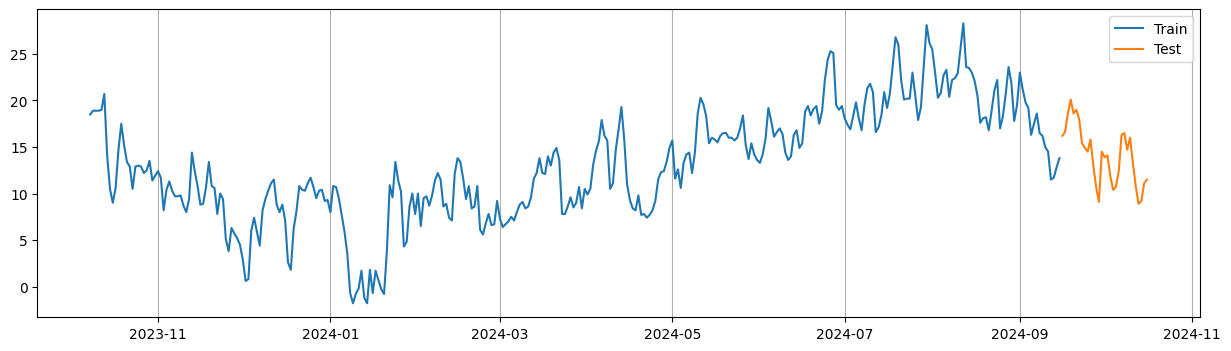

In [10]:
fig = plt.figure(figsize=(15,4))

plt.plot(train['temp'], label='Train')
plt.plot(test['temp'], label='Test')
plt.gca().xaxis.grid()
plt.legend()

### Normalize data

In [11]:
scale_target = StandardScaler()
scale_feature = StandardScaler()

train_normalized = pd.DataFrame(columns=train.columns, index=train.index)
test_normalized = pd.DataFrame(columns = test.columns, index=test.index)

train_normalized['temp'] = scale_target.fit_transform(train['temp'].to_frame())
train_normalized.iloc[:, 1:] = scale_feature.fit_transform(train.loc[:, train.columns != 'temp'])

test_normalized['temp'] = scale_target.transform(test['temp'].to_frame())
test_normalized.iloc[:, 1:] = scale_feature.transform(test.iloc[:, 1:])

test_normalized.head()

,temp,temp_lag1,temp_lag2,temp_lag3,temp_lag4,temp_lag5,temp_lag6,temp_lag7,tempmax_lag1,tempmin_lag1,feelslikemax_lag1,feelslikemin_lag1,feelslike_lag1,dew_lag1
datetime,,,,,,,,,,,,,,
2024-09-16,0.510067,0.109643,-0.057424,-0.241624,-0.276174,0.219931,0.299519,0.496471,0.418334,-0.313955,0.424292,-0.083794,0.198342,-0.246253
2024-09-17,0.576562,0.508415,0.108715,-0.058873,-0.242944,-0.277917,0.216721,0.29794,0.418334,0.492449,0.424292,0.590567,0.545936,0.511376
2024-09-18,0.909035,0.574877,0.50745,0.107265,-0.060181,-0.244727,-0.280071,0.215219,0.645182,0.722851,0.633962,0.77876,0.603869,0.716141
2024-09-19,1.158390,0.907187,0.573906,0.505995,0.105968,-0.062183,-0.246952,-0.281107,1.01381,0.780451,0.974676,0.825809,0.89353,0.941382
2024-09-20,0.909035,1.15642,0.906185,0.57245,0.504725,0.103767,-0.064795,-0.248019,1.269014,1.010853,1.210555,1.014002,1.110776,0.675188


### Prepare dataset

In [12]:
class ParisTemperatureTimeDelayEmbedding(Dataset):
    def __init__(self,  dataset):
        self.dataset = dataset

    def __getitem__(self, idx: int):
        features = self.dataset.iloc[idx, 1:].values
        target = self.dataset.iloc[idx, 0]

        features = torch.from_numpy(np.asarray(features, dtype='float')).float()
        target = torch.from_numpy(np.asarray(target)).float()
        return features, target


    def __len__(self):
        return self.dataset.shape[0]

In [13]:
train_dataset = ParisTemperatureTimeDelayEmbedding(train_normalized)
test_dataset = ParisTemperatureTimeDelayEmbedding(test_normalized)

In [14]:
test_dataset[0]

(tensor([ 0.1096, -0.0574, -0.2416, -0.2762,  0.2199,  0.2995,  0.4965,  0.4183,
         -0.3140,  0.4243, -0.0838,  0.1983, -0.2463]),
 tensor(0.5101))

In [15]:
batch = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

### Define model

In [16]:
class LstmOneHorizon(nn.Module):
    def __init__(self,hidden_size1 = 32, num_layers=1):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size = 1, hidden_size= hidden_size1, num_layers=num_layers, batch_first=True)
        self.regressor = nn.Linear(in_features=hidden_size1, out_features=1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        _, (x, _) = self.lstm1(x)
        # if (x.size(0) != 1):
        #     x = self.flatten(x)
        x = self.regressor(x)

        return x.squeeze()


In [17]:
model = LstmOneHorizon(hidden_size1=100).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

### Train

In [18]:
epochs = 1000
train_loss = []
test_loss = []
best_test_loss = 10000


for epoch in range(epochs):
    print('-' * 100)
    print(f'EPOCH [{epoch+1}/{epochs}]')


    model.train()
    loss_train_batch = 0 
    for i, (features, target) in enumerate(train_dataloader):
        features = features.to(device).unsqueeze(2)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(features)

        # In case batch only has 1 sample, output will be of shape []
        # The below "if" is to transform shape to [1] to make it comparable with 
        # the target
        # if (output.size() == torch.Size([])):
        #     output = output.unsqueeze(0)

        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        loss_train_batch += loss.item()

    train_loss.append(loss_train_batch/len(train_dataloader))


    model.eval()
    loss_val_batch = 0
    with torch.no_grad():
        for i, (features, target) in enumerate(test_dataloader):
            features = features.to(device).unsqueeze(2)
            target = target.to(device)

            output = model(features)

            # In case batch only has 1 sample, output will be of shape []
            # The below "if" is to transform shape to [1] to make it comparable with 
            # the target
            # if (output.size() == torch.Size([])):
            #     output = output.unsqueeze(0)
    
            vloss = loss_fn(output, target)

            loss_val_batch += vloss.item()

    scheduler.step(loss_train_batch/len(train_dataloader))

    test_loss.append(loss_val_batch/len(test_dataloader))
    print(f'Train loss: {loss_train_batch/len(train_dataloader)}, Validation loss: {loss_val_batch/len(test_dataloader)}')

    if (loss_val_batch < best_test_loss):
        best_test_loss = loss_val_batch
        print("New best model found")

plt.figure(figsize=(15,5))
plt.plot(np.arange(len(train_loss), dtype=int), train_loss, label='train')
plt.plot(np.arange(len(test_loss), dtype=int), test_loss, label= 'validation')
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()



----------------------------------------------------------------------------------------------------
EPOCH [1/1000]
Train loss: 0.9336502680724318, Validation loss: 0.24146031215786934
New best model found
----------------------------------------------------------------------------------------------------
EPOCH [2/1000]
Train loss: 0.3924136473373933, Validation loss: 0.20256009697914124
New best model found
----------------------------------------------------------------------------------------------------
EPOCH [3/1000]
Train loss: 0.2502212372015823, Validation loss: 0.14784707129001617
New best model found
----------------------------------------------------------------------------------------------------
EPOCH [4/1000]
Train loss: 0.2674908072433688, Validation loss: 0.14964664354920387
----------------------------------------------------------------------------------------------------
EPOCH [5/1000]
Train loss: 0.16597254726697097, Validation loss: 0.1353265978395939
New best mod

KeyboardInterrupt: 

### Test model

In [58]:
# model = LstmOneHorizon().to(device)
# model.load_state_dict(torch.load('../model/temp_norm_lstm_ts1_b16.pth'))

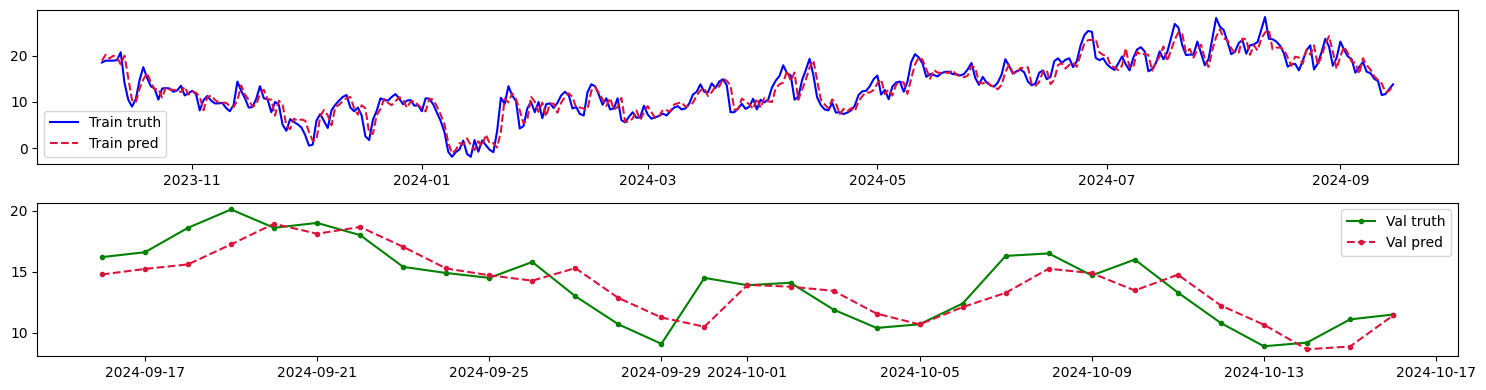

In [17]:
train_outputs = []
test_outputs = []
model.eval()
with torch.no_grad():
    for i, (features, target) in enumerate(train_dataloader):
        features = features.to(device).unsqueeze(2)
        target = target.to(device)

        output = model(features)

        # In case batch only has 1 sample, output will be of shape []
        # The below "if" is to transform shape to [1] to make it comparable with 
        # the target
        if (output.size() == torch.Size([])):
            output = output.unsqueeze(0)
        output = output.cpu().tolist()

        train_outputs += output
        

    for i, (features, target) in enumerate(test_dataloader):
        features = features.to(device).unsqueeze(2)
        target = target.to(device)

        output = model(features)

        # In case batch only has 1 sample, output will be of shape []
        # The below "if" is to transform shape to [1] to make it comparable with 
        # the target
        if (output.size() == torch.Size([])):
            output = output.unsqueeze(0)

        output = output.cpu().tolist()

        test_outputs += output

train_outputs = np.array(train_outputs).reshape(-1,1)
test_outputs = np.array(test_outputs).reshape(-1,1)

train_outputs = scale_target.inverse_transform(train_outputs)
test_outputs = scale_target.inverse_transform(test_outputs)


train_outputs = pd.Series(np.squeeze(train_outputs), index=train.index)
test_outputs = pd.Series(np.squeeze(test_outputs), index=test.index)

fig = plt.figure(figsize=(15,4))

fig.add_subplot(2,1,1)
plt.plot(train['temp'], label='Train truth', color='blue')
plt.plot(train_outputs,color='crimson', linestyle = 'dashed', label='Train pred')
plt.legend()


fig.add_subplot(2,1,2)
plt.plot(test['temp'], color='green', label='Val truth', marker='.')
plt.plot(test_outputs,color = 'crimson', linestyle = 'dashed',marker='.', label='Val pred')
plt.legend()

plt.tight_layout()


In [18]:
print(f"RMSE = {root_mean_squared_error(test['temp'], test_outputs)}")
print(f"R2 = {r2_score(test['temp'], test_outputs)}")
print(f"MAPE = {mean_absolute_percentage_error(test['temp'], test_outputs)}")

RMSE = 1.720960771886125
R2 = 0.6894171966121543
MAPE = 0.10128628831532317


In [61]:
# torch.save(model.state_dict(), f'../model/temp_norm_Lstm_ts{lags}_b{batch}_nl{num_layers}_.pth')

### Hyperparameter tuning

In [9]:
def lag_embedding_target(trial, ts):
    ts_name = ts.name
    lags = trial.suggest_int(f'{ts_name}_lag', 1, 10)
    ts_lag = pd.DataFrame({ts_name:ts})
        
    for i in range(lags):
        shift_ts = ts.shift(i+1).rename(f"{ts_name}_lag{i+1}")
        ts_lag = pd.concat([ts_lag, shift_ts], axis=1)

    ts_lag = ts_lag.dropna()

    return ts_lag


def lag_embedding_feature(trial, df,ts):
    ts_name = ts.name
    lags = trial.suggest_int(f'{ts_name}_lag', 1, 10)

    for i in range(lags):
        shift_ts = ts.shift(i+1).rename(f"{ts_name}_lag{i+1}")
        df = pd.concat([df, shift_ts], axis=1)

    df = df.dropna()

    return df


def split_train_test(ts, date='2024/09/15'):
    train = ts[ts.index <= pd.to_datetime(date)]
    test = ts[ts.index > pd.to_datetime(date)]

    return train, test
    

def normalize(train, test):
    scaler_target = StandardScaler()
    scaler_feature = StandardScaler()

    train_normalized = pd.DataFrame(columns=train.columns, index=train.index)
    test_normalized = pd.DataFrame(columns = test.columns, index=test.index)

    train_normalized['temp'] = scaler_target.fit_transform(train['temp'].to_frame())
    train_normalized.iloc[:, 1:] = scaler_feature.fit_transform(train.loc[:, train.columns != 'temp'])

    test_normalized['temp'] = scaler_target.transform(test['temp'].to_frame())
    test_normalized.iloc[:, 1:] = scaler_feature.transform(test.iloc[:, 1:])

    return train_normalized, test_normalized, scaler_target 


def get_dataloader(trial, train, test):
    batch = trial.suggest_int('batch_size', 8, 32)

    train_dataset = ParisTemperatureTimeDelayEmbedding(train)
    test_dataset = ParisTemperatureTimeDelayEmbedding(test)

    train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False)
    return train_dataloader, test_dataloader


def define_model(trial):
    hidden_size1 = trial.suggest_int("hidden_size1", 32, 256)
    model = LstmOneHorizon(hidden_size1=hidden_size1)
    return model


def objective(trial):
    df_lag = lag_embedding_target(trial, df['temp'] )
    df_lag = lag_embedding_feature(trial, df_lag, df['tempmax'])
    df_lag = lag_embedding_feature(trial, df_lag, df['tempmin'])
    df_lag = lag_embedding_feature(trial, df_lag, df['feelslikemax'])
    df_lag = lag_embedding_feature(trial, df_lag, df['feelslikemin'])
    df_lag = lag_embedding_feature(trial, df_lag, df['feelslike'])
    df_lag = lag_embedding_feature(trial, df_lag, df['dew'])

    train, test = split_train_test(df_lag)

    train_normalized, test_normalized, scaler_target = normalize(train, test)
    train_dataloader, test_dataloader = get_dataloader(trial, train_normalized, test_normalized)

    model = define_model(trial).to(device)
    loss_fn = nn.MSELoss()

    lr = trial.suggest_float("lr", 0.00001, 0.001, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.00001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    epochs = 1000
    train_loss = []


    for epoch in range(epochs):
        model.train()
        loss_train_batch = 0 
        for i, (features, target) in enumerate(train_dataloader):
            features = features.to(device).unsqueeze(2)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(features)

            if (output.size() == torch.Size([])):
                output = output.unsqueeze(0)

            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            loss_train_batch += loss.item()
        
        scheduler.step(loss_train_batch/len(train_dataloader))
        train_loss.append(loss_train_batch/len(train_dataloader))

        test_outputs = []

        with torch.no_grad():
            for i, (features, target) in enumerate(test_dataloader):
                features = features.to(device).unsqueeze(2)
                target = target.to(device)

                output = model(features)

                if (output.size() == torch.Size([])):
                    output = output.unsqueeze(0)

                output = output.cpu().tolist()

                test_outputs += output

        test_outputs = np.array(test_outputs).reshape(-1,1)
        test_outputs = scaler_target.inverse_transform(test_outputs)

        test_outputs = pd.Series(np.squeeze(test_outputs), index=test.index)

        rmse = root_mean_squared_error(test['temp'], test_outputs)
        trial.report(rmse, epoch) 

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return rmse



In [10]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

[I 2024-11-22 14:14:43,172] A new study created in memory with name: no-name-2959cc07-1a9a-4430-adc8-c602b5c95fab
[I 2024-11-22 14:15:40,137] Trial 0 finished with value: 1.9854826687121556 and parameters: {'temp_lag': 3, 'tempmax_lag': 2, 'tempmin_lag': 2, 'feelslikemax_lag': 1, 'feelslikemin_lag': 7, 'feelslike_lag': 7, 'dew_lag': 5, 'batch_size': 28, 'hidden_size1': 87, 'lr': 0.003567590124621931}. Best is trial 0 with value: 1.9854826687121556.
[I 2024-11-22 14:17:34,458] Trial 1 finished with value: 2.936917334504997 and parameters: {'temp_lag': 9, 'tempmax_lag': 3, 'tempmin_lag': 6, 'feelslikemax_lag': 10, 'feelslikemin_lag': 7, 'feelslike_lag': 8, 'dew_lag': 4, 'batch_size': 31, 'hidden_size1': 170, 'lr': 0.0002560793722145366}. Best is trial 0 with value: 1.9854826687121556.
[I 2024-11-22 14:19:45,884] Trial 2 finished with value: 1.8966208039914025 and parameters: {'temp_lag': 9, 'tempmax_lag': 6, 'tempmin_lag': 8, 'feelslikemax_lag': 8, 'feelslikemin_lag': 6, 'feelslike_lag':

KeyboardInterrupt: 

In [11]:
print(study.best_params)
print(study.best_trial.value)

{'temp_lag': 5, 'tempmax_lag': 6, 'tempmin_lag': 2, 'feelslikemax_lag': 4, 'feelslikemin_lag': 5, 'feelslike_lag': 5, 'dew_lag': 2, 'batch_size': 28, 'hidden_size1': 117, 'lr': 0.0037559858075508863}
1.6396651909281448


NameError: name 'plot_acf' is not defined

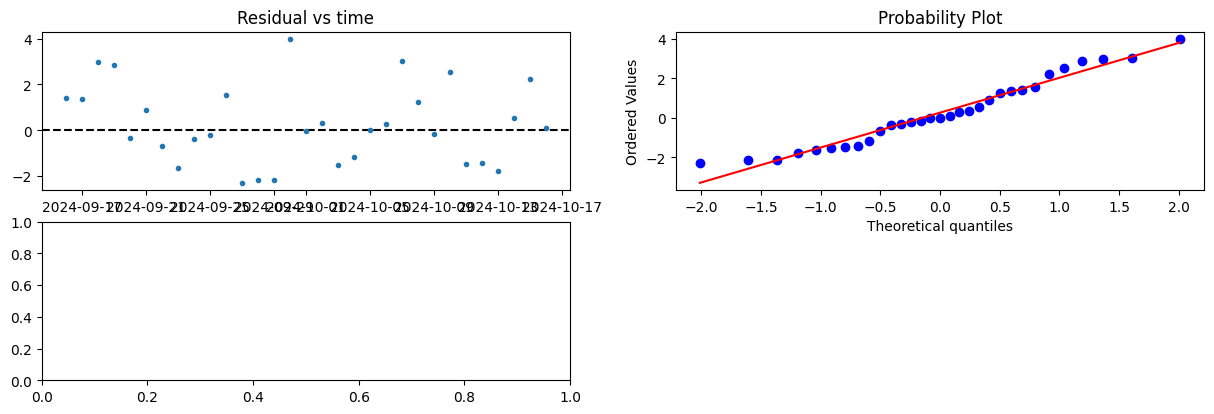

In [20]:
residuals = test['temp'] - test_outputs 
fig = plt.figure(figsize=(15, 7))

fig.add_subplot(3,2,1)
plt.axhline(0, color='k', linestyle='dashed')
plt.plot(residuals, '.')
plt.title("Residual vs time")

fig.add_subplot(3,2,2)
stats.probplot(residuals, dist="norm", plot=plt)

ax = fig.add_subplot(3,2,3)
plot_acf(residuals, lags=20, ax=ax, zero=False)

fig.add_subplot(3,2,4)
plt.scatter(test_outputs, residuals)
plt.title("Residual vs ground truth")

fig.add_subplot(3,2,5)
plt.boxplot(residuals, vert=False)
plt.title("Residual box plot")

plt.tight_layout()

In [ ]:
adf_test(residuals)